<a href="https://colab.research.google.com/github/bytoy/Project_CO/blob/main/modeling__(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. 패키지 설치**

In [1]:
# drive.mount
from google.colab import drive
drive._mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# package import
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from collections import Counter
from matplotlib import pyplot as plt

import keras
from keras import backend as K
from keras import layers
from keras.models import Model, Sequential, load_model, save_model
from keras.layers import Input, Dense, BatchNormalization

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

print(tf.version.VERSION)

2.7.0


## **1. Parameter Setting**

In [14]:
## parameter setting
# data
PATH = '/content/drive/MyDrive/'
PATH2 ='/content/drive/MyDrive/test/'
PATH3 = '/content/drive/MyDrive/npy/'

TRAIN_X_PATH = 'y_bin_replace_360_x13_224_25000.npy'
TRAIN_Y_PATH = 'y_bin_replace_360_x13_224_25000.npy'

NORMALIZATION = 359.0
IMAGE_SHAPE = 224
IMAGE_CHANNEL = 1

VALIDATION_SPLIT = 0.3
SPLIT_SHUFFLE = True

SEED = 34

MAX_COUNT_PER_ROTATION_224 = 600


# check point & early stopping
CHECK_POINT_PATH = 'check_point/tmp_checkpoint_2.ckpt/'
CHECK_POINT_FILEPATH = PATH + CHECK_POINT_PATH
CHECK_SAVE_BEST_ONLY = True
CHECK_VERBOSE = -1

EARLY_PATIENCE = 10
EARLY_MIN_DELTA = 0

CHECK_EARLY_MONITER = 'val_loss'
CHECK_EARLY_MODE = 'min'


# pre-trained model
VGG_MODEL_H5 = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
INCLUDE_TOP = False
PARAMETER_TRAINING = False


# model
MODEL_SAVE = 'model.h5'
NUM_CLASSES = 1

## **2. Data Import, Normalization, Split, Sample Weight**

In [ ]:
"""
이전 학습 결과를 기반으로 train, validation 데이터를 일부 filtering 했을경우 아래의 코드 실행 

# data import & normalization
# data import & normalization
x_train = np.load(PATH + 'x_train.npy')
y_train = np.load(PATH + 'y_train.npy')
x_valid = np.load(PATH + 'x_valid.npy')
y_valid = np.load(PATH + 'y_valid.npy')

target = np.concatenate((y_train, y_valid), axis=0)
print(f'target data shape: {target.shape}')
print(f'y_train data shape: {y_train.shape}')
print(f'y_valid data shape: {y_valid.shape}')
"""

In [16]:
# data import & normalization
data = np.load(PATH3 + TRAIN_X_PATH)
target = np.load(PATH3 + TRAIN_Y_PATH)

print(f'image data shape: {data.shape}')
print(f'label data shape: {target.shape}')
print(f'train_y unique values: {list(set(target))[0:5]}')
print(f'train_y unique values length: {len(set(target))}')

image data shape: (154469,)
label data shape: (154469,)
train_y unique values: [0, 1, 2, 3, 4]
train_y unique values length: 360


In [17]:
# train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(data,
                                                      target,
                                                      test_size = VALIDATION_SPLIT,
                                                      shuffle = SPLIT_SHUFFLE,
                                                      stratify = target,
                                                      random_state = SEED)

print(f'x_train data shape: {x_train.shape}')
print(f'x_valid data shape: {x_valid.shape}')
print(f'y_train data shape: {y_train.shape}')
print(f'y_valid data shape: {y_valid.shape}')

x_train data shape: (108128,)
x_valid data shape: (46341,)
y_train data shape: (108128,)
y_valid data shape: (46341,)


In [19]:
# 각도 별 이미지 개수 정보를 딕셔너리로 생성
weight = dict(Counter(target))

# 1로 채워진 리스트 생성
sample_weight_train = np.ones(shape = (len(y_train) ,))
sample_weight_val = np.ones(shape = (len(y_valid) ,))

# 회전 각도 별 가중치를 생성하고 해당 각도를 갖는 인덱스 지점의 값을 가중치로 변경한다
for label, count in weight.items() :
  cor = int((MAX_COUNT_PER_ROTATION_224 - count)/100)
  sample_weight_train[y_train == label] = cor
  sample_weight_val[y_valid == label] = cor

# 정규화 진행
y_train = y_train / NORMALIZATION
y_valid = y_valid / NORMALIZATION

## **3. Model Setting, Complie, Train**

In [7]:
# check point
check_point = ModelCheckpoint(filepath = CHECK_POINT_FILEPATH,
                              monitor = CHECK_EARLY_MONITER,
                              save_best_only = CHECK_SAVE_BEST_ONLY,
                              mode = CHECK_EARLY_MODE,
                              verbose = CHECK_VERBOSE)

# early stopping
early_stopping = EarlyStopping(monitor = CHECK_EARLY_MONITER,
                               min_delta = EARLY_MIN_DELTA,
                               patience = EARLY_PATIENCE,
                               mode = CHECK_EARLY_MODE)

# image reshape
img_input = layers.Input(shape = (IMAGE_SHAPE,
                                  IMAGE_SHAPE,
                                  IMAGE_CHANNEL))

img_conc = layers.Concatenate()([img_input,
                                 img_input,
                                 img_input])

# pre-trained model
base_model = VGG16(
    weights = PATH + VGG_MODEL_H5,
    include_top = INCLUDE_TOP, 
    input_tensor = img_conc)

for layer in base_model.layers:
    layer.trainable = PARAMETER_TRAINING

In [8]:
# model setting & compile
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(256,
                       activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128,
                       activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64,
                       activation = 'relu',
                       kernel_regularizer = regularizers.l2(0.00001),
                       activity_regularizer = regularizers.l1(0.00001)))
model.add(layers.Dense(32,
                       activation = 'relu',
                       kernel_regularizer = regularizers.l2(0.00001),
                       activity_regularizer = regularizers.l1(0.00001)))
model.add(layers.Dense(NUM_CLASSES,
                       activation = 'sigmoid'))

model.compile(
        loss = 'mse',
        optimizer = Adam(learning_rate = 0.001),
        metrics = ['mse'])

In [13]:
model.load_weights(CHECK_POINT_FILEPATH)

NotFoundError: ignored

In [ ]:
# training
history = model.fit(x_train, y_train, 
          validation_data = (x_valid, y_valid, sample_weight_val),
          epochs = 1,
          batch_size = 128,
          sample_weight = sample_weight_train,
          callbacks = [early_stopping,
                       check_point])

845/845 [==============================] - ETA: 0s - loss: 0.0343 - mse: 0.0321

## **4. Evaluation**

In [ ]:
save_model(model, PATH + MODEL_SAVE, overwrite = True, include_optimizer = True)

In [12]:
model_2 = load_model(PATH + MODEL_SAVE, custom_objects = None, compile = True)

In [ ]:
x_train = x_train.reshape(-1, 224, 224, 1)

In [21]:
# 모델 학습 결과 확인
prediction = model_2.predict(test[0:100])

# 학습 결과를 담은 리스트 생성
result = []
for i in range(len(prediction)) :
  result.append(prediction[i][0])

# 실제값과 예측값의 차이 계산 및 단위 보정 결과를 담은 리스트 생성
diff = []
for pred, label in zip(result, y_train) :
  diff.append(abs(pred - label) * NORMALIZATION)

# 오름차순 정렬을 위한 리스트 복제
diff_2 = diff.copy()
diff_2.sort(reverse = True)

# 결과 출력
for i in diff_2[0:50] :
  index = diff.index(i)
  print("pred {2}".format(round(diff[index]), round(y_train[index]*359), round(result[index]*359)))

pred 0
pred 359
pred 359
pred 359
pred 359
pred 359
pred 359
pred 359
pred 359
pred 359
pred 359
pred 356
pred 359
pred 359
pred 0
pred 359
pred 0
pred 0
pred 1
pred 359
pred 0
pred 122
pred 64
pred 359
pred 52
pred 1
pred 34
pred 49
pred 356
pred 52
pred 102
pred 86
pred 1
pred 0
pred 355
pred 162
pred 0
pred 178
pred 56
pred 359
pred 0
pred 148
pred 144
pred 190
pred 359
pred 341
pred 171
pred 357
pred 155
pred 142


In [ ]:
# 모델 학습 결과 확인
prediction = model.predict(x_train[0:100])
prediction[0]

# # 학습 결과를 담은 리스트 생성
# result = []
# for i in range(len(prediction)) :
#   result.append(prediction[i][0]*359)
#   # print("for image {0} angle: {1}, pred: {2}".format(i, angle, pred))

# print(result)

array([0.00141118], dtype=float32)

In [ ]:
# 2도 이내 기준으로 학습 데이터의 정답, 오답 수 계산
correct_train = 0
incorrect_train = 0

for i in diff_train :
  if i > 2 :
    incorrect_train += 1
  else :    
    correct_train += 1

print(f"2도 이내 정답: {correct_train}, 2도 이내 오답: {incorrect_train}, 정답률: {correct_train/len(x_train)}")

2도 이내 정답: 100, 2도 이내 오답: 0, 정답률: 0.0010278865624389693


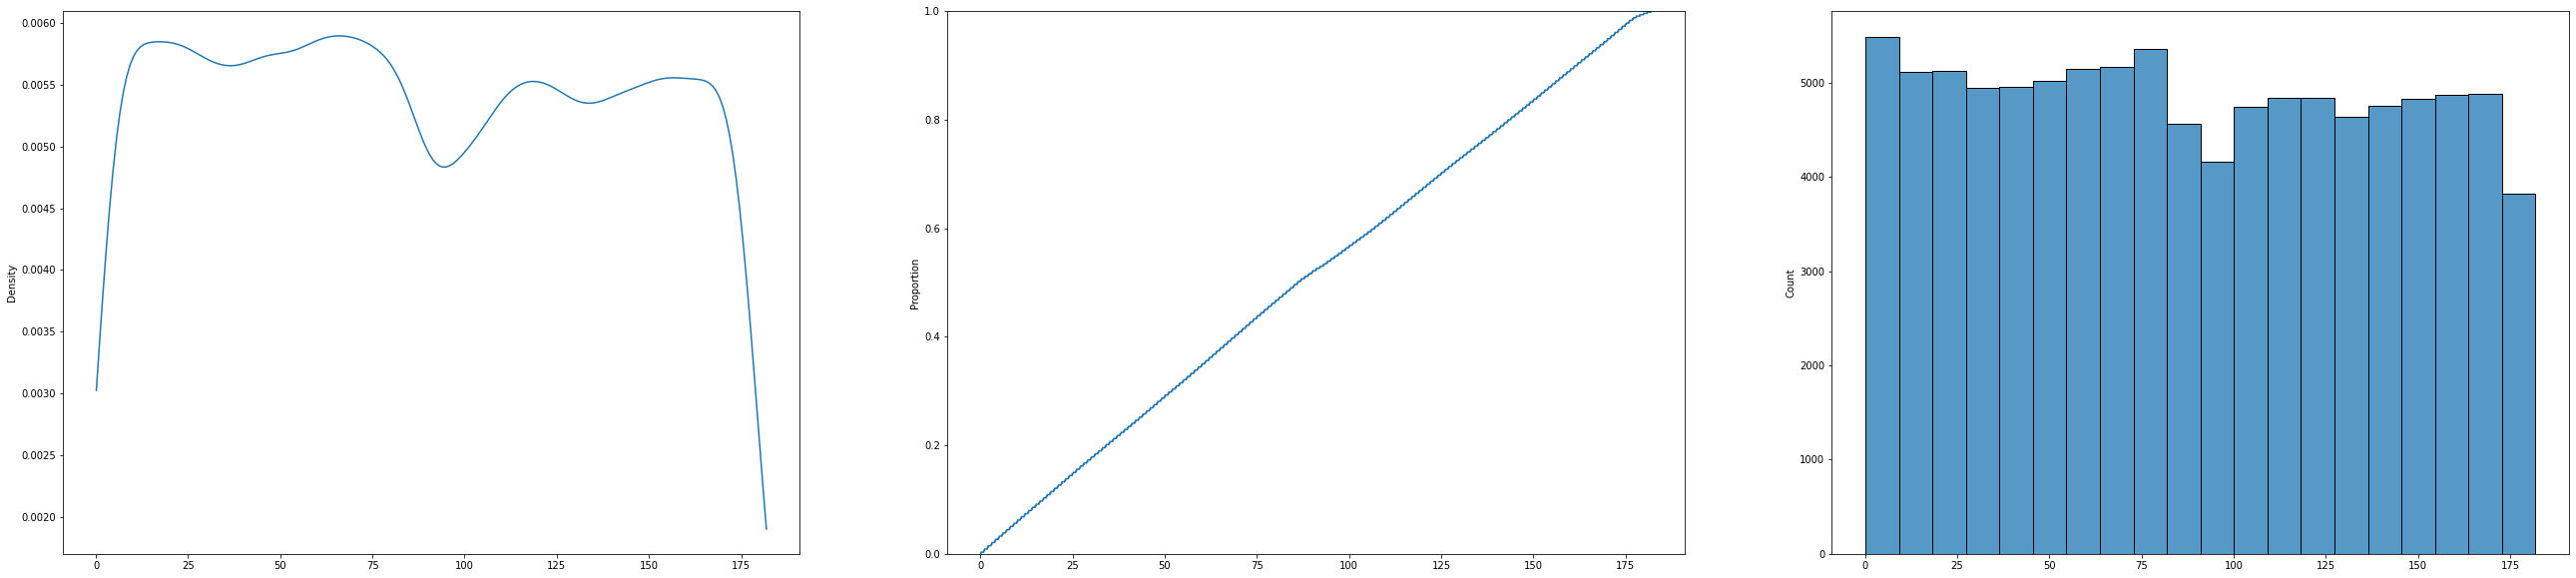

In [ ]:
# KDE, ECDF, Histogram으로 학습 데이터의 결과 시각화
fig, ax = plt.subplots(1, 3, figsize = (45, 10))
sns.kdeplot(diff_train, cut = 0, ax = ax[0]);
sns.ecdfplot(diff_train, ax = ax[1]);
sns.histplot(diff_train, bins = 20, ax = ax[2]);